# <font color="green">Desafío- Clasificación de calidad de ramen</font>

## <font color="green">Descripción</font>

 En este proyecto de Machine Learning, se te ha encomendado la tarea de construir un
 modelo de clasificación que determine si un paquete de ramen es <b>"bueno" o "malo"</b>
 basándose en sus características específicas. Para ello, se proporciona un conjunto de
 datos que contiene información sobre diferentes marcas de ramen y sus atributos, así como
 una etiqueta que indica si el ramen fue considerado como <b>"bueno" o "malo"</b> por expertos o
 usuarios.
 Para cumplir este objetivo necesitarás:

1. Realizar un análisis exhaustivo de calidad de datos para identificar y tratar posibles
 valores faltantes, valores atípicos y errores en los datos. Garantizar que el conjunto
 de datos esté limpio y preparado para su posterior procesamiento y entrenamiento
 de los modelos.


In [139]:
pip install category-encoders

In [140]:
#realizamos los imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             roc_curve,
                             roc_auc_score,
                             precision_recall_curve)
from sklearn.model_selection import cross_val_score
from category_encoders import TargetEncoder, CountEncoder


In [141]:
ramen = pd.read_excel('ramen-ratings.xlsx')
ramen.shape

(2580, 7)

In [142]:
ramen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


In [143]:
ramen['Variety'].unique()

array(["T's Restaurant Tantanmen",
       'Noodles Spicy Hot Sesame Spicy Hot Sesame Guan-miao Noodles',
       'Cup Noodles Chicken Vegetable', ...,
       'Hu Tiu Nam Vang ["Phnom Penh" style] Asian Style Instant\xa0Rice\xa0Noodles',
       'Oriental Style Instant Noodles', 'Tom Yum Chili Flavor'],
      dtype=object)

In [144]:
ramen['Top Ten'].unique()

array([nan, '2016 #10', '2016 #1', '2016 #8', '2016 #5', '2016 #9',
       '2016 #7', '2015 #10', '2015 #7', '2015 #4', '2015 #9', '2015 #6',
       '2015 #1', '2013 #10', '2015 #8', '2014 #7', '2014 #4', '2014 #9',
       '2014 #10', '2014 #8', '2014 #5', '2014 #6', '2014 #1', '2013 #1',
       '2013 #2', '2013 #4', '\n', '2013 #9', '2013 #3', '2012 #10',
       '2012 #7', '2012 #5', '2012 #3', '2012 #6', '2012 #9', '2012 #1',
       '2012 #2', '2013 #6', '2012 #4'], dtype=object)

In [145]:
#transformaré stars a numeros para poder entrenar los datos
ramen['Stars'] = ramen['Stars'].replace('Unrated', None).astype(float)
#elimino los none
ramen = ramen.dropna(subset=['Stars'])
ramen['Stars'].head(3)

,Stars
0,3.75
1,1.00
2,2.25


In [146]:
#busco el promedio de las clasificaciones y en base al resultado
#decido si es bueno o malo
promedio = ramen['Stars'].mean()
promedio

np.float64(3.6546759798214974)

In [147]:
#contar todas las estrellas menores a 3.5
ramen[ramen['Stars'] < promedio].shape

(1096, 7)

In [148]:
#cambiaré los estilos nulos por la moda
ramen['Style'] = ramen['Style'].fillna(ramen['Style'].mode()[0])

In [149]:
ramen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2577 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review #  2577 non-null   int64  
 1   Brand     2577 non-null   object 
 2   Variety   2577 non-null   object 
 3   Style     2577 non-null   object 
 4   Country   2577 non-null   object 
 5   Stars     2577 non-null   float64
 6   Top Ten   41 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 161.1+ KB


 2. Realizar el preprocesamiento de los datos, incluyendo la normalización o
 estandarización de las características, codificación de variables categóricas y
 división del conjunto de datos en conjuntos de entrenamiento y prueba.


In [150]:
# Crear la variable binaria objetivo
ramen["Good"] = (ramen["Stars"] >= promedio).astype(int)

In [151]:
#eliminaremos las columnas review# y top ten que no aportan nada a los datos
#numero de reseña no tiene nada que ver con el analisis
#top ten no tiene datos suficientes como para que se quede
#stars por que la reemplazamos con good
ramen.drop(['Review #', 'Top Ten', 'Stars'], axis=1, inplace=True)
ramen.head(3)

,Brand,Variety,Style,Country,Good
0,New Touch,T's Restaurant Tantanmen,Cup,Japan,1
1,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,0
2,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,0


In [152]:
#voy a dividir el data set usando starts como las etiquetas
X = ramen[["Brand", "Variety", "Style", "Country"]]
y = ramen["Good"]

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
target_enc = TargetEncoder(cols=["Brand", "Country", "Style"], smoothing=0.3)
count_enc = CountEncoder(cols=["Variety"])

In [155]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

X_train_enc[["Brand", "Country", "Style"]] = target_enc.fit_transform(
    X_train[["Brand", "Country", "Style"]], y_train
)
X_test_enc[["Brand", "Country", "Style"]] = target_enc.transform(
    X_test[["Brand", "Country", "Style"]]
)

In [156]:
X_train_enc[["Variety"]] = count_enc.fit_transform(X_train[["Variety"]])
X_test_enc[["Variety"]] = count_enc.transform(X_test[["Variety"]])

In [157]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

 3. Dividir los datos en conjuntos de entrenamiento y prueba y entrenar dos modelos de
 clasificación: uno utilizando Regresión Logística y otro utilizando Support Vector
 Machine (SVM). Estos modelos servirán para determinar si un paquete de ramen es
 "bueno" o "malo" en función de las características proporcionadas y realiza una
 búsqueda de hiperparámetros.


# <font color='blue'>Regresion logistica</font>

In [158]:
loreg = LogisticRegression(max_iter=1000, class_weight='balanced')
loreg.fit(X_train_scaled, y_train)
y_pred_loreg = loreg.predict(X_test_scaled)

In [159]:
print("Accuracy test:", accuracy_score(y_test, y_pred_loreg))
print(classification_report(y_test, y_pred_loreg))
print(confusion_matrix(y_test, y_pred_loreg))

Accuracy test: 0.6143410852713178
              precision    recall  f1-score   support

           0       0.54      0.45      0.49       214
           1       0.65      0.73      0.69       302

    accuracy                           0.61       516
   macro avg       0.60      0.59      0.59       516
weighted avg       0.61      0.61      0.61       516

[[ 97 117]
 [ 82 220]]


# <font color="darkred">Los datos son muy bajos para el valor 0 por lo que tiende a predecir mejor los valores calificados como buenos, 1</font>

en resumen, detecta muchos ramens malos como buenos

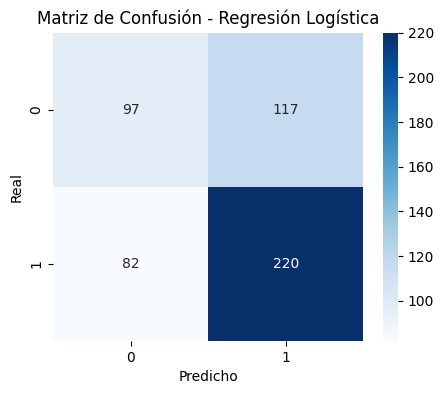

In [160]:
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred_loreg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

 4. Evaluar el rendimiento de ambos modelos utilizando métricas relevantes para
 problemas de clasificación, como precisión, recall, F1-score y el área bajo la curva
 ROC (AUC-ROC). A partir de esto, debes comparar y analizar los resultados obtenidos por cada modelo para determinar cuál es más adecuado para este problema
 específico.

# <font color='blue'>SVM</font>

In [161]:
# Definir la grilla
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

svm = SVC(class_weight='balanced')

In [167]:
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [168]:

print("Mejores parámetros encontrados:")
print(grid.best_params_)
print(f"Mejor accuracy promedio: {grid.best_score_:.3f}")

Mejores parámetros encontrados:
{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Mejor accuracy promedio: 0.659


In [170]:
best_svm = grid.best_estimator_
best_svm.fit(X_train_scaled, y_train)

y_pred_svm = best_svm.predict(X_test_scaled)
y_proba_svm = best_svm.decision_function(X_test_scaled)

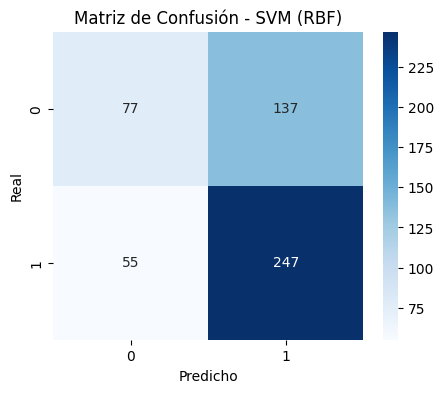

In [171]:
# --- Matriz de confusión ---
plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - SVM (RBF)")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

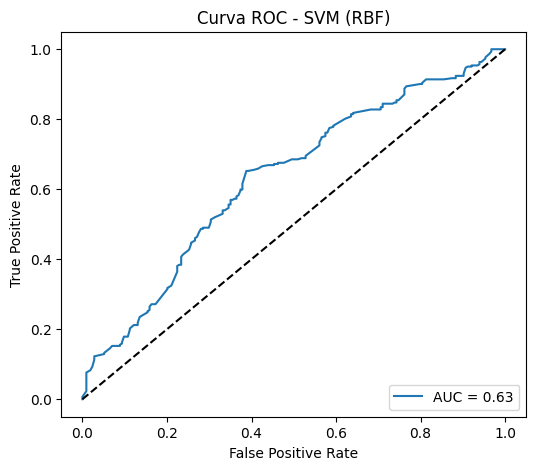

In [172]:
# --- Curva ROC ---
fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
roc_auc = roc_auc_score(y_test, y_proba_svm)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("Curva ROC - SVM (RBF)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

Apenas distingue entre si es bueno o malo el ramen

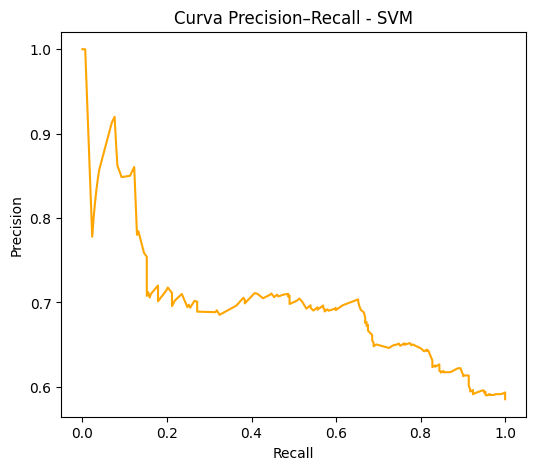

In [173]:
# --- Curva Precision–Recall ---
precision, recall, _ = precision_recall_curve(y_test, y_proba_svm)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='orange')
plt.title("Curva Precision–Recall - SVM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

no hay mucha diferencia